In [1]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 1.5MB 23.2MB/s 
     |████████████████████████████████| 2.9MB 55.8MB/s 
     |████████████████████████████████| 890kB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=99d055fe7a6d8a27c6e80666ff184a78a43f9ebf0552968e3ad626c1aba48787
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.1MB 16.2MB/s 


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, AutoTokenizer

# specify GPU
device = torch.device("cuda")

In [3]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install indic-nlp-library
import sys
from indicnlp import common

# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"indic_nlp_resources"

# Add library to Python path
sys.path.append(r'{}\src'.format(INDIC_NLP_LIB_HOME))

# Set environment variable for resources folder
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp.tokenize import sentence_tokenize, indic_tokenize

Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 133 (delta 0), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (133/133), 149.77 MiB | 41.90 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [4]:
train_file = 'train.csv'
val_file = 'val.csv'
test_file = 'test.csv'

In [5]:
train_data = pd.read_csv(train_file, header=0, index_col=0)
val_data = pd.read_csv(val_file, header=0, index_col=0)
non_hostile_val_data = pd.read_csv('y_pred_val_non_hostile.csv', header=0, index_col=0)
test_data = pd.read_csv(test_file, header=0, index_col=0)
train_val_data = train_data.append(val_data, ignore_index=True)

In [6]:
non_hostile_test_data = pd.read_csv('y_pred_test_non_hostile.csv', header=0, index_col=0)
val_data_orig = val_data

In [7]:
train_data.drop(train_data[train_data['Labels Set']=='non-hostile'].index, inplace = True)
val_data.drop(non_hostile_val_data[non_hostile_val_data['non-hostile']==1].index, inplace=True)
train_val_data.drop(train_val_data[train_val_data['Labels Set']=='non-hostile'].index, inplace = True)

In [8]:
test_data.drop(non_hostile_test_data[non_hostile_test_data['non-hostile']==1].index, inplace=True)

In [9]:
print(train_data.shape)
train_data.head()

(2678, 13)


,Post,Labels Set,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post,Filtered_Post_Stopword_Removed,Unnamed: 12,Unnamed: 13
Unique ID,,,,,,,,,,,,,
1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive",[],[],[],[],"['🙏', '🙏']",[],[],मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश हिन्दु निराले है। पक्के राम भक्त बाबर...,NaN,NaN
4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive",[],[],['@prabhav218'],[],[],[],[],साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते...,साले जेएनयू छाप कमिने लोग हिन्दुओं संविधान सबक...,NaN,NaN
6,चीन ने UN में तर्क दिया की भारत का विपक्ष ही अ...,fake,[],[],[],[],[],[],[],चीन ने UN में तर्क दिया की भारत का विपक्ष ही अ...,चीन UN तर्क भारत विपक्ष अजर‌ मसुद आतंकी मानता ...,NaN,NaN
11,RT @_Pb_swain_: मोदीजी और जब सारा देश सेना के ...,hate,[],[],['@_Pb_swain_:'],[],['🤔'],[],['RT'],"मोदीजी और जब सारा देश सेना के साथ खडी है,\n\...","मोदीजी देश सेना खडी है, सयाने विदेश पडे है? बो...",NaN,NaN
12,RT @ShilpiSinghINC: 48000 घरों को तोड़ने का आद...,offensive,[],[],['@ShilpiSinghINC:'],[],[],[],['RT'],"48000 घरों को तोड़ने का आदेश आया है, किसी को...","48000 घरों तोड़ने आदेश आया है, फर्क़ पड़ता! अम...",NaN,NaN


In [10]:
print(val_data.shape)
val_data.head()

(379, 11)


,Post,Labels Set,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post,Filtered_Post_Stopword_Removed
Unique ID,,,,,,,,,,,
2,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...,defamation,[],[],[],[],[],[],[],भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...,भारतीय जनता पार्टी rss इतने गिरे हूं मेरी जासू...
8,अद्भुत - जो वामपंथी कहते है कि महाभारत का युद्...,fake,[],[],[],[],[],[],[],अद्भुत - जो वामपंथी कहते है कि महाभारत का युद्...,"अद्भुत - वामपंथी महाभारत युद्ध काल्पनिक है, सन..."
13,भाई जाके हिन्दू भाइयों की मदद कर जिनकी नौकरी च...,offensive,[],[],[],[],[],[],[],भाई जाके हिन्दू भाइयों की मदद कर जिनकी नौकरी च...,भाई जाके हिन्दू भाइयों मदद जिनकी नौकरी चली आत्...
14,यह दुर्घटना कन्नूर अंतर्राष्ट्रीय हवाई अड्डे म...,fake,[],[],[],[],[],[],[],यह दुर्घटना कन्नूर अंतर्राष्ट्रीय हवाई अड्डे म...,"दुर्घटना कन्नूर अंतर्राष्ट्रीय हवाई अड्डे हुई,..."
15,सत्य कभी कमजोर नही होने देता। और “ज्ञान” कभी द...,non-hostile,[],[],[],[],[],[],[],सत्य कभी कमजोर नही होने देता। और “ज्ञान” कभी द...,सत्य कमजोर नही देता। “ज्ञान” दुःखी भयभीत नही द...


In [11]:
labels_set = {'defamation',
 'fake',
 'hate',
 'non-hostile',
 'offensive'}

labels_mapping = {'defamation':0,
 'fake':1,
 'hate':2,
 'non-hostile':3,
 'offensive':4}

In [12]:
from collections import defaultdict
import ast
mentions_dict = defaultdict(int)

for index, row in train_data.iterrows():
  if 'hate' in row['Labels Set']:
    mentions = ast.literal_eval(row['mentions']) 
    for m in mentions:
      mentions_dict[m]+=1


In [13]:
filtered_mentions_list = []

for key, value in mentions_dict.items():
  if value > 1:
    filtered_mentions_list.append(key)

In [14]:
mention_len = len(filtered_mentions_list)

In [15]:
mention_len

60

In [16]:
hashtag_dict = defaultdict(int)

for index, row in train_data.iterrows():
  if 'hate' in row['Labels Set']:
    mentions = ast.literal_eval(row['hashtags']) 
    for m in mentions:
      hashtag_dict[m]+=1


In [17]:
filtered_hashtag_list = []

for key, value in hashtag_dict.items():
  if value > 1:
    filtered_hashtag_list.append(key)

In [18]:
hash_len = len(filtered_hashtag_list)

In [19]:
hash_len

27

In [20]:
emoji_dict = defaultdict(int)

for index, row in train_data.iterrows():
  if 'hate' in row['Labels Set']:
    emojis = ast.literal_eval(row['emojis']) 
    for e in emojis:
      emoji_dict[e]+=1


In [21]:
filtered_emoji_list = []

for key, value in emoji_dict.items():
  if value > 3:
    filtered_emoji_list.append(key)

In [22]:
emoji_len = len(filtered_emoji_list)

In [23]:
emoji_len

25

In [25]:
df = pd.read_csv('hate_words.csv', header=None)
# hate_dict = dict(zip(df[0],df[1]))
hate_dict = list(df[0])

In [26]:
hateness_len = len(hate_dict)
print(hateness_len)

50


In [27]:
offensive_words_list = ['कुत्ते','कुत्ते','कुतिया', 'कुते', 'कुत्ती', 'कुत्तों', 'कमीने', 'कमीना', 'कमीनी', 'साले', 'साला', 'साली', 'हरामी', 'हरामखोर', 'बहनचोद', 'बहिनचोद', 'भेंचो', 'मादरचोद', 'माचोद', 'चूतिये', 'चूतिया', 'चुत', 'चूत', 'लवड़ा', 'लंड', 'लन्ड', 'लँड', 'लण्ड', 'लौड़ा', 'लोडे', 'भड़वो', 'भड़ुआ', 'भड़ऊ', 'भड़वे', 'भड्वे', 'रन्डी', 'रांड', 'भोसड़ी', 'गांड', 'बेटीचोद', 'बेटिचोद', 'फट्टू', 'फुददू', 'फुद्दु', 'सुअर', 'झांट', 'ना󰀂ाय󰀂', 'टट्टी', 'ह󰀂󰀂󰀂डे', 'हुरो', 'गद्दार', 'सूअरों', 'हरामि', 'गाली', 'गॉड', 'रडुआ', 'लुच्चे', 'भड़वागिरी', 'बेवकूफ', 'कुत्तो', 'मूर्खों', 'बकवास', 'तब्लीघि', 'चोरी']

In [28]:
def generate_matrix(data):
  X = np.empty((0,  1 + emoji_len+hash_len + mention_len+ hateness_len+len(offensive_words_list)))

  for index, row in data.iterrows():
    x = np.zeros((1, 1))
    x[0, 0] = 1  # Bias Unit

    hateness = np.zeros((1,hateness_len))
    for word in indic_tokenize.trivial_tokenize(row['Filtered_Post_Stopword_Removed'], lang='hi'):
      if word in hate_dict:
        hateness[0, hate_dict.index(word)] =1

    # Offensive Words
    offensive_word_count_x = np.zeros((1, len(offensive_words_list)))
    for word in row['Filtered_Post_Stopword_Removed'].split(' '):
      if word in offensive_words_list:
        offensive_word_count_x[0,offensive_words_list.index(word)]= 1

    hash_x = np.zeros((1, hash_len))
    # Hashtags
    for h in ast.literal_eval(row['hashtags']):
      if h in filtered_hashtag_list:
        hash_x[0, filtered_hashtag_list.index(h)] = 1

    
    mention_x = np.zeros((1, mention_len))
    # Mentions
    for h in ast.literal_eval(row['mentions']):
      if m in filtered_mentions_list:
        mention_x[0, filtered_mentions_list.index(m)] = 1

    emoji_x = np.zeros((1, emoji_len))
    # Emojis
    for h in ast.literal_eval(row['emojis']):
      if h in filtered_emoji_list:
        emoji_x[0, filtered_emoji_list.index(h)] = 1

    x = np.hstack((x, hateness, hash_x, mention_x, emoji_x, offensive_word_count_x))
    X = np.vstack((X, x))
  return X


In [29]:
train_X = generate_matrix(train_data)
val_X = generate_matrix(val_data)

In [30]:
train_y = np.empty((0, 5))
for index, row in train_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  train_y = np.vstack((train_y, y))


val_y = np.empty((0, 5))
for index, row in val_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  val_y = np.vstack((val_y, y))


In [31]:
y_train_hate = train_y[:,2].astype(int)
y_val_hate = val_y[:,2].astype(int)

train_sentences = train_data['Post'].values
val_sentences = val_data['Post'].values

**BERT**

In [32]:
bert = AutoModel.from_pretrained('ai4bharat/indic-bert')
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')

In [33]:
# sample data
text = ["जिसमें लिखा है, काश के कश्मीर के पत्थरबाज़ इन नवजवानों से कुछ सीखते। #भारतीयसेना ।", "सुशांत के परिवार पर अब किसका 'कीचड़'?"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[2, 18654, 670, 48660, 4384, 12, 128648, 1883, 128648, 26697, 1883, 43991, 42191, 1793, 1325, 464, 6151, 1325, 10759, 1301, 1883, 12286, 54111, 229, 15, 1078, 8297, 229, 1134, 8731, 7, 3], [2, 1301, 2700, 229, 1883, 37, 555, 37, 311, 9854, 507, 27, 507, 232, 1546, 398, 293, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


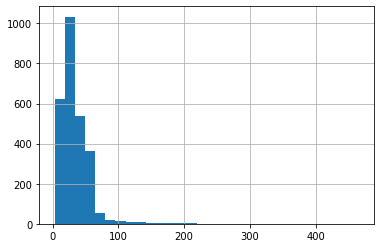

In [34]:
seq_len = [len(i.split()) for i in train_sentences]

pd.Series(seq_len).hist(bins = 30)

In [35]:
tokens_train = tokenizer.batch_encode_plus(
    train_sentences.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_sentences.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train_hate.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val_hate.tolist())

In [37]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 4

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = SequentialSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
train_other_ft_dataloader = DataLoader(train_X, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
val_other_ft_dataloader = DataLoader(val_X, sampler=val_sampler, batch_size=batch_size)

In [38]:
for param in bert.parameters():
    param.requires_grad = False

In [39]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768+1+ hateness_len+ mention_len+hash_len+emoji_len+len(offensive_words_list),512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, other_ft):
      other_ft = other_ft.float()
      #pass the inputs to the model
      state= self.bert(sent_id, attention_mask=mask)
      cls_hs = state.pooler_output
      x = self.fc1(torch.hstack((cls_hs, other_ft)))
      x = self.relu(x)

      if self.train():
        x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [40]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [41]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-3)          # learning rate

In [42]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train_hate), y_train_hate)

print("Class Weights:",class_weights)

Class Weights: [0.70996819 1.69065657]


In [43]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 10

In [44]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for first,second in zip(enumerate(train_dataloader), enumerate(train_other_ft_dataloader)):
    step, batch = first
    _, other_ft = second
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    other_ft = other_ft.to(device)
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask, other_ft)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [46]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for first,second in zip(enumerate(val_dataloader), enumerate(val_other_ft_dataloader)):
    step, batch = first
    _, other_ft = second
    other_ft = other_ft.to(device)
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask, other_ft)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [47]:
epoch = 10
optimizer = AdamW(model.parameters(),
                  lr = 2e-5)   

In [48]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    670.
  Batch   100  of    670.
  Batch   150  of    670.
  Batch   200  of    670.
  Batch   250  of    670.
  Batch   300  of    670.
  Batch   350  of    670.
  Batch   400  of    670.
  Batch   450  of    670.
  Batch   500  of    670.
  Batch   550  of    670.
  Batch   600  of    670.
  Batch   650  of    670.

Evaluating...
  Batch    50  of     95.

Training Loss: 0.686
Validation Loss: 0.680

 Epoch 2 / 10
  Batch    50  of    670.
  Batch   100  of    670.
  Batch   150  of    670.
  Batch   200  of    670.
  Batch   250  of    670.
  Batch   300  of    670.
  Batch   350  of    670.
  Batch   400  of    670.
  Batch   450  of    670.
  Batch   500  of    670.
  Batch   550  of    670.
  Batch   600  of    670.
  Batch   650  of    670.

Evaluating...
  Batch    50  of     95.

Training Loss: 0.679
Validation Loss: 0.677

 Epoch 3 / 10
  Batch    50  of    670.
  Batch   100  of    670.
  Batch   150  of    670.
  Batch   200  of    670.
  B

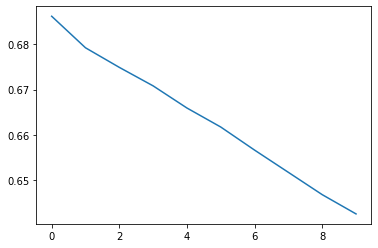

In [49]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

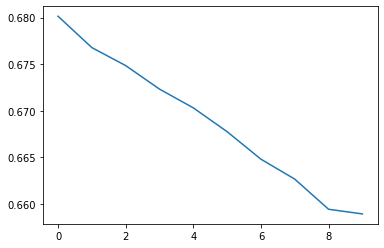

In [50]:
plt.plot(valid_losses)

In [51]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [52]:
with torch.no_grad():
  preds = model(val_seq.to(device), val_mask.to(device), torch.from_numpy(val_X).to(device))
  preds = preds.detach().cpu().numpy()

In [53]:
preds = np.argmax(preds, axis = 1)
print(classification_report(y_val_hate, preds))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       269
           1       0.45      0.43      0.44       110

    accuracy                           0.68       379
   macro avg       0.61      0.61      0.61       379
weighted avg       0.68      0.68      0.68       379



In [54]:
result_df = pd.DataFrame(preds, index = val_data_orig.index, columns=['hate'])
result_df.index.name = 'Unique ID'
result_df.to_csv('y_pred_val_hate.csv')